# Build a new BART tool and code test

Author: Jon Tamir jtamir@utexas.edu

This notebook describes and demonstrates how to add a new command-line tool to BART, and create a system test for it. Typically, this workflow would be performed directly in the terminal or through a programming IDE. For demonstration purposes, we will use Jupyter Notebook with the bash kernel. 

## Learning objectives
The goals of this tutorial are the following:
- Understand the layout of the BART code (`src`, `lib`, `tests`, etc.)
- Understand the layout of a BART tool (main function, library calls)
- Understand how to add compile a new BART tool
- Understand how to add a system test to test correctness and demonstrate functionality

As a motivating example, we will build a new tool, `nuecalib`, that performs ESPIRiT calibration for non-Cartesian data:
1. Load a non-Cartesian trajectory and kspace dataset with `C` coils
1. Perform inverse NUFFT followed by forward Cartesian FFT
1. Perform ESPIRiT sensitivity map calibration on the Cartesian kspace

These steps can already be performed by chaining existing command-line tools (`nufft`, `fft`, and `ecalib`):

This tutorial is not intended to describe in detail the actual code, but instead can be used as a reference.

**For more information, see the following papers:**
Pruessmann KP, Weiger M, Scheidegger MB, Boesiger P. SENSE: Sensitivity encoding for fast MRI. Magn Reson Med 1999; 42:952-962.

Pruessmann KP, Weiger M, Boernert P, Boesiger P. Advances in sensitivity encoding with arbitrary k-space trajectories. Magn Reson Med 2001; 46:638-651.

Uecker M, Lai P, Murphy MJ, Virtue P, Elad M, Pauly JM, Vasanawala SS, Lustig M. ESPIRiT - An Eigenvalue Approach to Autocalibrating Parallel MRI: Where SENSE meets GRAPPA. Magn Reson Med, 71:990-1001 (2014)


**For an additional example of building a new tool in BART, see the tutorial given in previous BART workshops:**

https://github.com/mrirecon/bart-workshop/blob/master/demos/sense-recon/sense-recon.ipynb

## Setup instructions


### Option 1: run through Binder
If you are running this through the Binder, there should be no additional setup steps. To replicate this on your own system, follow the following setup instructions.

### Option 2: run locally
#### Install bash kernel for Jupyter
To run this notebook, install the bash kernel for Jupyter:  
https://github.com/takluyver/bash_kernel

```bash
pip install bash_kernel
python -m bash_kernel.install
```

#### Checkout BART v0.5.00
We will work with BART v0.5.00. These steps should work with other verions of BART, but it is recommended to check out this version so that the tutorial instructions match the code.

We can check out this version of BART and compile with the following command:
```bash
git clone --branch v0.5.00 https://github.com/mrirecon/bart
cd bart
PARALLEL=1 make test
source startup.sh
```

Before getting started, let's make a helper function for displaying images. We will use the BART command toimg, which can convert BART files to pngs. If our session supports X-windows forwarding, we can instead use the BART viewer, view, to open an interactive viewer

In [1]:
# BASH function to write BART file to png,
# display the png, and then temove it
function imshow () {
    bart toimg -W $1 $1.png > /dev/null
    cat $1.png | display
    rm $1.png
}

## BART code layout

Navigate to the bart directory as shown above. Before doing so, save the webinar files directory for later use:

In [2]:
pwd
export WEBINAR_PATH=$(pwd)

/home/jovyan


In [3]:
cd ${TOOLBOX_PATH}
pwd

/home/jovyan/bart


There are a few main directories of interest:
- [`doc`](https://github.com/mrirecon/bart/tree/master/doc): Contains documentation for common uses in BART, including building new tools
- [`src`](https://github.com/mrirecon/bart/tree/master/src): Contains the source files for all tools and libraries
- [`lib`](https://github.com/mrirecon/bart/tree/master/lib): Contains compiled libraries that can be included by various tools
- [`tests`](https://github.com/mrirecon/bart/tree/master/tests): Contains system test code, to test functionality of BART tools
- [`utests`](https://github.com/mrirecon/bart/tree/master/utests): Contains unit test code, to test functionality of BART functions
- [`Makefiles`](https://github.com/mrirecon/bart/tree/master/Makefiles): Contains custom make rules

### Source files
Source files are found under [`src`](https://github.com/mrirecon/bart/tree/master/src). The command-line tools are found directly under [`src`](https://github.com/mrirecon/bart/tree/master/src), while library files are nested within a sub-directory. For example, the  [`src/noncart`](https://github.com/mrirecon/bart/tree/master/src/noncart) directory contains the source files that comprise the non-Cartesian library:

In [4]:
ls -l src/noncart

total 92
-rw-r--r-- 1 jovyan jovyan  9666 Jun  1 06:49 grid.c
-rw-r--r-- 1 jovyan jovyan  1871 Jun  1 06:49 grid.h
-rw-r--r-- 1 jovyan jovyan  5774 Jun  1 06:49 nudft.c
-rw-r--r-- 1 jovyan jovyan  1413 Jun  1 06:49 nudft.h
-rw-r--r-- 1 jovyan jovyan 29460 Jun  1 06:49 nufft.c
-rw-r--r-- 1 jovyan jovyan  2300 Jun  1 06:49 nufft.h
-rw-r--r-- 1 jovyan jovyan  1826 Jun  1 06:49 nufft_priv.h
-rw-r--r-- 1 jovyan jovyan  4176 Jun  1 06:49 precond.c
-rw-r--r-- 1 jovyan jovyan   377 Jun  1 06:49 precond.h
-rw-r--r-- 1 jovyan jovyan  4654 Jun  1 06:49 traj.c
-rw-r--r-- 1 jovyan jovyan  1054 Jun  1 06:49 traj.h


### System tests
System test files are found under [`tests`](https://github.com/mrirecon/bart/tree/master/tests). The system tests can be used to make sure BART functionality does not break after new code is added. It also serves as a self-contained example. We will add a file here that will test our new command-line tool

In [5]:
ls -l tests

total 204
-rw-r--r-- 1 jovyan jovyan  2500 Jun  1 06:49 bin.mk
-rw-r--r-- 1 jovyan jovyan   640 Jun  1 06:49 casorati.mk
-rw-r--r-- 1 jovyan jovyan  3483 Jun  1 06:49 ccapply.mk
-rw-r--r-- 1 jovyan jovyan  2022 Jun  1 06:49 cc.mk
-rw-r--r-- 1 jovyan jovyan   352 Jun  1 06:49 cdf97.mk
-rw-r--r-- 1 jovyan jovyan 14017 Jun  1 06:49 CMakeLists.txt
-rw-r--r-- 1 jovyan jovyan  1088 Jun  1 06:49 copy.mk
-rw-r--r-- 1 jovyan jovyan  2139 Jun  1 06:49 ecalib.mk
-rw-r--r-- 1 jovyan jovyan  2418 Jun  1 06:49 estdelay.mk
-rw-r--r-- 1 jovyan jovyan   428 Jun  1 06:49 estshift.mk
-rw-r--r-- 1 jovyan jovyan   812 Jun  1 06:49 extract.mk
-rw-r--r-- 1 jovyan jovyan  1601 Jun  1 06:49 fft.mk
-rw-r--r-- 1 jovyan jovyan   819 Jun  1 06:49 filter.mk
-rw-r--r-- 1 jovyan jovyan   411 Jun  1 06:49 flatten.mk
-rw-r--r-- 1 jovyan jovyan   425 Jun  1 06:49 fmac.mk
-rw-r--r-- 1 jovyan jovyan  2517 Jun  1 06:49 gpu.mk
-rw-r--r-- 1 jovyan jovyan  1443 Jun  1 06:49 homodyne.mk
-rw-r--r-- 1 jovyan jovyan   566 Jun  1 

### Makefiles
The [`Makefiles`](https://github.com/mrirecon/bart/tree/master/Makefiles) directory can be used to put custom Makefile commands without modifying the main Makefile. We will use this directory to tell BART to compile our custom tool

## New command: `nuecalib`
We will create a new command, `nuecalib`, for performing ESPIRiT calibration for non-Cartesian data. The tool usage will be the following:
```bash
> bart nuecalib -h
Usage: nuecalib [-m d] [-d d] [-t f] [-c f] <kspace> <traj> <sensitivities>

Estimate coil sensitivities from non-Cartesian data using
ESPIRiT calibration.
This tool is for demonstration purposes only and does not
have the full functionality of `nufft` or `ecalib`.

-m maps      	Number of maps to compute.
-d level      	Debug level
-t threshold      	This determines the size of the null-space.
-c crop_value      	Crop the sensitivities if the eigenvalue is smaller than {crop_value}.
-h		help
```

The tool will be equivalent to the following series of existing commands:
```bash
bart nufft -i traj kspace cimg
bart fft -u 7 cimg ksp_grid
bart ecalib -m maps -d level -t threshold -c crop_value ksp_grid sensitivities
rm -f cimg.cfl cimg.hdr ksp_grid.cfl ksp_grid.hdr
```
We will use these commands as the basis for our system test.

### Copy source code for `nuecalib.c` into `src` directory
The source code for the new tool is in the webinar directory and can be copied with the following command:

In [6]:
cp ${WEBINAR_PATH}/data/nuecalib/nuecalib.c src/

The source code is documented line-by-line to be used as a reference. Let's look at a few snippets:

**We include BART modules for different functionality, including numerical operations, iterative optimization, NUFFT, linear operators, file I/O, and more**

In [7]:
sed -n '14,30p' < src/nuecalib.c

#include "misc/mmio.h" // used for input-output operations, like load_cfl
#include "misc/mri.h" // contains defs for dimensions, like COIL_DIM
#include "misc/debug.h" // used for printing debug info
#include "misc/opts.h" // for command-line argument parsing

#include "num/multind.h" // multi-dim array functions
#include "num/flpmath.h" // used for CFL_SIZE def
#include "num/fft.h" // fast Fourier transform functions
#include "num/init.h" // CPU/GPU intialization routines

#include "calib/calib.h" // library containing routines for ESPIRiT calibration

#include "linops/linop.h" // library containing linear operator routines

#include "iter/lsqr.h" // library containing least squares solver

#include "noncart/nufft.h" // library containing non-uniform FFT


**We define the human-readable usage and help strings after importing the libraries**

In [8]:
sed -n '37p' < src/nuecalib.c

sed -n '42,46p' < src/nuecalib.c

static const char usage_str[] = "<kspace> <traj> <sensitivities>";
static const char help_str[] =
		"Estimate coil sensitivities from non-Cartesian data using\n"
		"ESPIRiT calibration.\n"
		"This tool is for demonstration purposes only and does not\n"
		"have the full functionality of `nufft` or `ecalib`.";


**Each command-line tool defines a main function:**

In [9]:
sed -n '53,54p' < src/nuecalib.c

int main_nuecalib(int argc, char* argv[])
{


**We next define the input-output and optional arguments.** Our tool will take three required arguments (trajectory, kspace data, and output sensitivities). It will have a few command-line arguments to pass to ESPIRiT calibration

**After initializing, we load the input data as memory-mapped files**

In [10]:
sed -n '94,100p' < src/nuecalib.c

	// load trajectory
	long traj_dims[DIMS];
	complex float* traj = load_cfl(argv[1], DIMS, traj_dims);

	// load kspace data
	long ksp_dims[DIMS];
	complex float* ksp = load_cfl(argv[2], DIMS, ksp_dims);


**We create the NUFFT linear operator and solve for the inverse NUFFT to get coil images**

In [11]:
sed -n '102,108p' < src/nuecalib.c

	/*
	 * Step 1: perform iterative NUFFT.
	 * We will use the noncart library. The sub-steps are the following:
	 * 1. Estimate image dimensions based on trajectory
	 * 2. Construct an NUFFT linear operator
	 * 3. Perform least squares fit to iteratively compute the inverse NUFFT 
	 */


In [12]:
sed -n '129,133p' < src/nuecalib.c

	// create NUFFT linear operator (used by lsqr)
	const struct linop_s* nufft_op = nufft_create(DIMS, ksp_dims, cimg_dims, traj_dims, traj, NULL, nuconf);

	// solve for NUFFT inverse using LSQR and store in cimg	
	lsqr(DIMS, &(struct lsqr_conf){ 0., false }, iter_conjgrad, CAST_UP(&cgconf), nufft_op, NULL, cimg_dims, cimg, ksp_dims, ksp, NULL);


**We take the Cartesian FFT of the coil images to get Cartesian kspace and perform ESPIRiT calibration**

In [13]:
sed -n '138,144p' < src/nuecalib.c

	/* 
	 * Step 2: estimate Sensitivity maps using ESPIRiT.
	 * We will use the calib library. The sub-steps are the following:
	 * 1. Take the FFT of the coil-image, cimg, and store in ksp_grid
	 * 2. Extract a calibration region from the center of k-space
	 * 3. Run the ESPIRiT algorithm
	 */


**Take the forward FFT of coil images**

In [14]:
sed -n '148p' < src/nuecalib.c

	fftuc(DIMS, cimg_dims, FFT_FLAGS, ksp_grid, cimg);


**Extract calibration data from gridded kspace**

In [15]:
sed -n '156p' < src/nuecalib.c

	complex float* cal_data = extract_calib(cal_dims, calsize, cimg_dims, ksp_grid, false);


**Run ESPIRiT**

In [16]:
sed -n '181p' < src/nuecalib.c

	calib(&econf, sens_dims, sens, emaps, K, svals, cal_dims, cal_data); 


**Clean up and clear memory**

In [17]:
sed -n '188,198p' < src/nuecalib.c

	md_free(cal_data);
	md_free(emaps);

	unmap_cfl(DIMS, ksp_dims, ksp);
	unmap_cfl(DIMS, traj_dims, traj);
	unmap_cfl(DIMS, sens_dims, sens);


	printf("Done.\n");
	return 0;
}


### Add custom Makefile for new tool
Copy the custom Makefile to the `Makefiles` directory. The custom Makefile tells BART what dependencies our new tool will have, and adds the tool to the build targets

In [18]:
cp ${WEBINAR_PATH}/data/nuecalib/Makefile.nuecalib Makefiles/

In [19]:
cat Makefiles/Makefile.nuecalib

MODULES_nuecalib = -lcalib -lnoncart -liter -llinops
XTARGETS += nuecalib


We can now compile the new tool with the command, `make`. However, if we only want to compile the new tool and not the full repository, we can specify this tool only. It is recommended to append `PARALLEL=1` to compile in parallel when possible.

If using the Binder, this may take 1-2 minutes

In [20]:
PARALLEL=1 make | grep make

make MAKESTAGE=2 
make[1]: Entering directory '/home/jovyan/bart'
make allclean || rm isclean
make[2]: Entering directory '/home/jovyan/bart'
make[2]: Leaving directory '/home/jovyan/bart'
ar: creating lib/libbox.a
ar: creating lib/libcalib.a
ar: creating lib/libmisc.a
ar: creating lib/libsense.a
ar: creating lib/libiter.a
ar: creating lib/liblinops.a
ar: creating lib/libgrecon.a
ar: creating lib/libgeom.a
ar: creating lib/libnum.a
ar: creating lib/libnoir.a
ar: creating lib/libnlops.a
ar: creating lib/libnoncart.a
ar: creating lib/libsake.a
ar: creating lib/libwavelet.a
ar: creating lib/libsimu.a
ar: creating lib/libmoba.a
ar: creating lib/liblowrank.a
ar: creating lib/libdfwavelet.a
make[1]: Leaving directory '/home/jovyan/bart'


Now when we type `bart` in the command-line, we will see our new tool in the list:

In [21]:
bart

BART. Available commands are:
avg         bench       bin         bitmask     cabs        caldir      
calmat      carg        casorati    cc          ccapply     cdf97       
circshift   conj        conv        copy        cpyphs      creal       
crop        delta       ecalib      ecaltwo     estdelay    estdims     
estshift    estvar      extract     fakeksp     fft         fftmod      
fftrot      fftshift    filter      flatten     flip        fmac        
homodyne    index       invert      itsense     join        looklocker  
lrmatrix    mandelbrot  mip         moba        nlinv       noise       
normalize   nrmse       nuecalib    nufft       ones        pattern     
phantom     pics        pocsense    poisson     poly        repmat      
reshape     resize      rmfreq      rof         rss         rtnlinv     
sake        saxpy       scale       sdot        show        slice       
spow        sqpics      squeeze     ssa         std         svd         
tgv         threshold

: 1

We can invoke our command with `bart nuecalib`:

In [22]:
bart nuecalib -h

Usage: nuecalib [-d d] [-m d] [-t f] [-c f] <kspace> <traj> <sensitivities>

Estimate coil sensitivities from non-Cartesian data using
ESPIRiT calibration.
This tool is for demonstration purposes only and does not
have the full functionality of `nufft` or `ecalib`.

-d level      	Debug level
-m maps      	Number of maps to compute.
-t threshold      	This determines the size of the null-space.
-c crop_value      	Crop the sensitivities if the eigenvalue is smaller than {crop_value}.
-h		help


### Test the tool on simulated data
We will now create phantom non-Cartesian data and compare our method to the existing CLI tools.

In [23]:
export DEBUG_LEVEL=3

In [24]:
NX=256 # x dim
NY=256 # y dim
NC=4 # num coils

bart traj -G -x ${NX} -y ${NY} trj2 # create a non-Cartesian trajectory
bart scale 0.5 trj2 trj # rescale trajectory to avoid infolding artifacts
bart phantom -k -s ${NC} -t trj ksp # create Shepp-logan kspace phantom using trj trajectory with 4 coils

non-Cartesian kspace data


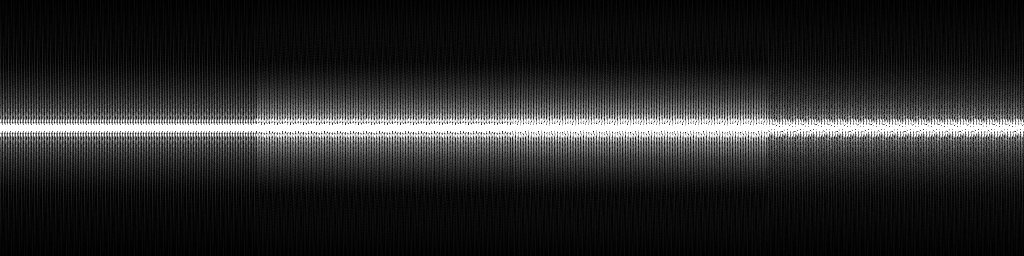

In [25]:
echo "non-Cartesian kspace data"
bart reshape `bart bitmask 2 3` $((${NY} * ${NC})) 1 ksp ksp_flat
imshow ksp_flat
rm -f ksp_flat.cfl ksp_flat.hdr

inverse NUFFT
Est. image size: 128 128 1
ksp : [  1 256 256   4   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [128 128   1   4   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 256 256   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
Allocating 65536 (vs. 131072) + 65536
ksp : [  1 256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Done.


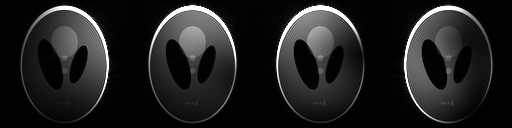

In [26]:
echo "inverse NUFFT"
bart nufft -i trj ksp cimg

bart reshape `bart bitmask 1 3` $((${NY}/2 * ${NC})) 1 cimg cimg_flat
imshow cimg_flat
rm -f cimg_flat.cfl cimg_flat.hdr

forward FFT


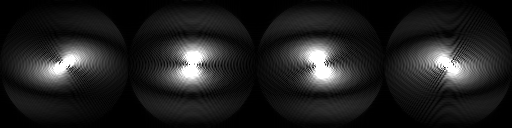

In [27]:
echo "forward FFT"
bart fft -u 3 cimg ksp_grid

bart reshape `bart bitmask 1 3` $((${NY}/2 * ${NC})) 1 ksp_grid ksp_grid_flat
imshow ksp_grid_flat
rm -f ksp_grid_flat.cfl ksp_grid_flat.hdr

ESPIRiT Calibration
Calibration region...  (size: 24x24x1, pos: 53x52x0)
Energy: 0.806 0.169 0.024 0.001
Build calibration matrix and SVD...
Eigen decomposition... (size: 144)
Using 37/144 kernels (25.69%, last SV: 0.041694).
Zeropad...
FFT (juggling)...
Calculate Gram matrix...
Resize...
Point-wise eigen-decomposition...
Crop maps... (c = 0.50)
Fix phase...
Done.


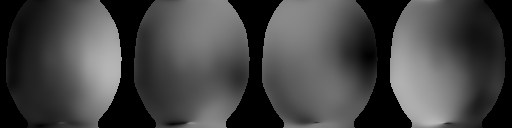

In [28]:
echo "ESPIRiT Calibration"
M=1 # number of ESPIRiT maps
T=.0015 # step 1 threshold
C=.5 # step 2 threshold
bart ecalib -d 3 -m ${M} -t ${T} -c ${C} ksp_grid sens

bart reshape `bart bitmask 1 3 4` $((${M} * ${NY}/2 * ${NC})) 1 1 sens sens_flat
imshow sens_flat
rm -f sens_flat.cfl sens_flat.hdr

**Compare to output of our new tool**

[128 128   1   4   1   1   1   1   1   1   1   1   1   1   1   1 ]
Est. image size: 128 128 1
ksp : [  1 256 256   4   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [128 128   1   4   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 256 256   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
Allocating 65536 (vs. 131072) + 65536
ksp : [  1 256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Calibration region...  (size: 24x24x1, pos: 53x52x0)
Energy: 0.806 0.169 0.024 0.001
Build calibration matrix and SVD...
Eigen decomposition... (size: 144)
Using 37/144 kernels (25.69%, last SV: 0.041694).
Zeropad...
FFT (juggling)...
Calculate Gram matrix...
Resize...
Point-wise eigen-decomposition...
Crop maps... (c = 0.50)
Fix phase...
Done.


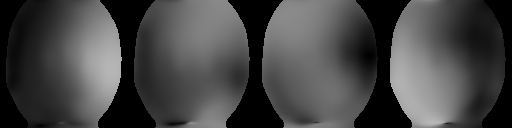

In [29]:
bart nuecalib -d 3 -m ${M} -t ${T} -c ${C} trj ksp sens2

bart reshape `bart bitmask 1 3 4` $((${M} * ${NY}/2 * ${NC})) 1 1 sens2 sens2_flat
imshow sens2_flat
rm -f sens2_flat.cfl sens2_flat.hdr

In [30]:
echo "Normalized RMSE between sensitivity maps:"
bart nrmse sens sens2

Normalized RMSE between sensitivity maps:
0.000005


## Add system-level test
We can take the steps above and create a system test out of it. The test will essentially check that our tool is functioning correctly.

Copy the test file to the `tests` directory. The custom test tells BART what commands to run when building the system tests


In [31]:
cp ${WEBINAR_PATH}/data/nuecalib/nuecalib.mk tests/

In [32]:
cat tests/nuecalib.mk



# compare to nufft, fft, and ecalib

tests/test-nuecalib: traj scale phantom nufft fft ecalib nuecalib nrmse 
	set -e; mkdir $(TESTS_TMP) ; cd $(TESTS_TMP)					;\
	$(TOOLDIR)/traj -G -x128 -y128 traj2.ra						;\
	$(TOOLDIR)/scale 0.5 traj2.ra traj.ra						;\
	$(TOOLDIR)/phantom -k -s 4 -t traj.ra ksp_noncart.ra				;\
	$(TOOLDIR)/nufft -i traj.ra ksp_noncart.ra cimg.ra				;\
	$(TOOLDIR)/fft -u 3 cimg.ra ksp_grid.ra						;\
	$(TOOLDIR)/ecalib -m2 -c .5 -t .002 ksp_grid.ra sens.ra				;\
	$(TOOLDIR)/nuecalib -m2 -c .5 -t .002 traj.ra ksp_noncart.ra sens2.ra		;\
	$(TOOLDIR)/nrmse -t 0.0001 sens.ra sens2.ra					;\
	rm *.ra ; cd .. ; rmdir $(TESTS_TMP)
	touch $@

TESTS += tests/test-nuecalib 


We can see that the test relies on a number of other BART commands, including `traj`, `scale`, `phantom`, and others. The test file is a sequence of BART and bash commands. The commands essentially replicate workflow above. The final BART command, `nrmse`, compares the two approaches and makes sure their error is small.

**We can automatically run the test when compiling with `make test`.** Alternatively, we can specify the single test we want to build.

In [33]:
PARALLEL=1 make tests/test-nuecalib

make MAKESTAGE=2 tests/test-nuecalib
make[1]: Entering directory '/home/jovyan/bart'
gcc -Wall -Wextra -MMD -MF /home/jovyan/bart/src/.traj.d -iquote /home/jovyan/bart/src/ -I/usr//include/ -I/usr//include -DFFTWTHREADS -DMAIN_LIST="avg, bench, bin, bitmask, cabs, caldir, calmat, carg, casorati, cc, ccapply, cdf97, circshift, conj, conv, copy, cpyphs, creal, crop, delta, ecalib, ecaltwo, estdelay, estdims, estshift, estvar, extract, fakeksp, fft, fftmod, fftrot, fftshift, filter, flatten, flip, fmac, homodyne, index, invert, itsense, join, looklocker, lrmatrix, mandelbrot, mip, moba, nlinv, noise, normalize, nrmse, nuecalib, nufft, ones, pattern, phantom, pics, pocsense, poisson, poly, repmat, reshape, resize, rmfreq, rof, rss, rtnlinv, sake, saxpy, scale, sdot, show, slice, spow, sqpics, squeeze, ssa, std, svd, tgv, threshold, toimg, traj, transpose, twixread, upat, var, vec, version, walsh, wave, wavelet, wavepsf, whiten, window, wshfl, zeros, zexp, ()" -include src/main.h -O3 -ffast

The build succeeded, indicating that our test has passed! If the test had failed, then `make` would have exited with an error.

## Short summary
In this example, we showed the BART C-code structure, added a new command, added a system test for the command, and ran it on simulated data. We accomplished this with the following main steps:
- we added the main source code to the `src` directory,
- we added a custom Makefile to the `Makefiles` directory to specify the BART module dependencies
- we added a system test to the `tests` directory to test the functionality/correctness of the new tool

Thank you for joining our webinar! We hope you had some fun with it and learned a lot! :)